# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [1]:
# # Для работы в колабе раскоменьте эти строки
!git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
%cd DeepGenerativeModels/

Cloning into 'DeepGenerativeModels'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 656 (delta 85), reused 161 (delta 56), pack-reused 447
Receiving objects: 100% (656/656), 179.42 MiB | 14.22 MiB/s, done.
Resolving deltas: 100% (265/265), done.
/content/DeepGenerativeModels


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%time
!mkdir -p data/celeba
!cp ../drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/GAN/second/list_attr_celeba.txt data/celeba/list_attr_celeba.txt
!cp ../drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/GAN/second/img_align_celeba.zip data/celeba/img_align_celeba.zip
!unzip -q data/celeba/img_align_celeba.zip -d data/celeba

CPU times: user 349 ms, sys: 74.6 ms, total: 424 ms
Wall time: 55.2 s


In [4]:
#!g1.1
import sys; sys.path.append('utils/datasets/')
from celeba import CelebADataset

import os 
import math
import shutil
import numpy as np
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import trange, tqdm

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid

In [5]:
#!g1.1
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

In [6]:
#!g1.1
class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        sex_index = self.header.index('Male')
        label = {-1: 0, 1: 1}[int(target['attributes'][sex_index])]
        return image, label

dataset = CelebaCustomDataset(transform=transform)

img, label = dataset[0]
img.shape, label

(torch.Size([3, 64, 64]), 0)

### Визуализация датасета

In [7]:
#!g1.1
def plot_img(img, label, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    # plt.title(f'label = {label}')
    plt.axis('off')

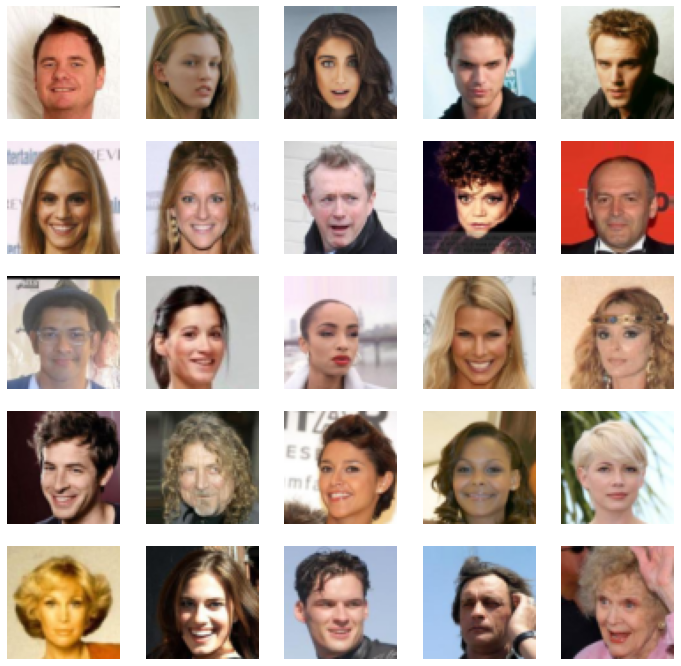

In [8]:
#!g1.1
plt.figure(figsize=(12, 12))

for i in range(25):
    img, label = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, label, t_invnormalize)
plt.show()

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

#### Real-NVP model

In [27]:
# YOUR CODE HERE
sys.path.append('seminars/seminar-7-nf/')
from nflib.flows import AffineHalfFlow, NormalizingFlowModel
from torch.distributions import MultivariateNormal

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

dim_size = 64*64*3 # for reshape 2D-image into 1D-vector
prior = MultivariateNormal(torch.zeros(dim_size).to(device), 
                           torch.eye(dim_size).to(device))
flows = [AffineHalfFlow(dim=dim_size, parity=i%2).to(device) for i in range(9)]
model = NormalizingFlowModel(prior, flows).to(device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#### Training

In [39]:
def tensor2numpy(x):
    return x.detach().cpu().numpy().transpose(1,2,0)

def denormalize(x):
    return np.clip(t_invnormalize(x), 0, 1)

In [40]:
batch_size = 8
dataset = CelebaCustomDataset(transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

Loss: ?:   0%|          | 0/1500 [00:00<?, ?it/s]

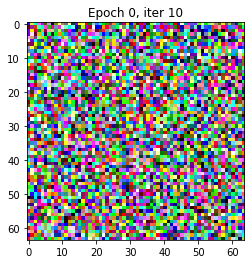

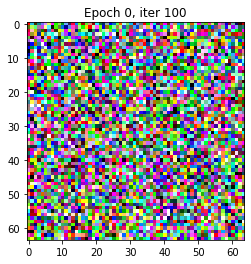

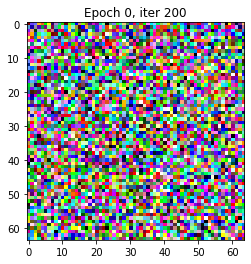

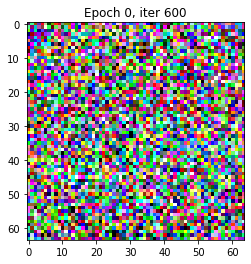

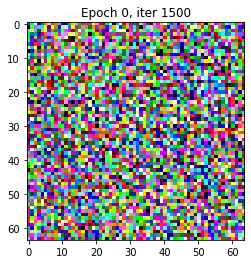

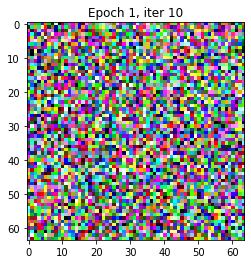

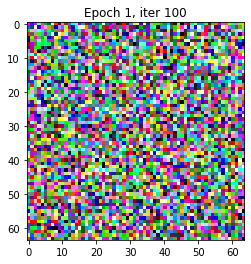

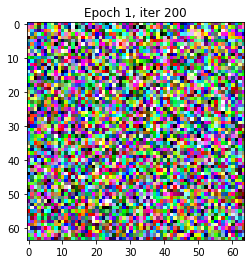

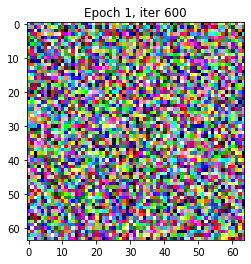

KeyboardInterrupt: ignored

In [42]:
n_epoches = 1
limit = 1500
model.train()
pbar = tqdm(range(n_epoches*limit), desc='Loss: ?')

for k in pbar:
    for i, (data, _) in enumerate(dataloader):
        data = data.view(batch_size, -1).to(device)

        zs, prior_logprob, log_det = model(data)
        logprob = prior_logprob + log_det
        loss = -torch.sum(logprob) # NLL

        model.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description(f'Loss: {(loss.item()/dim_size):.2f}')
        pbar.refresh()

        if i in [10, 100, 200, 600, 1500]:
            with torch.no_grad():
                sample = model.sample(1) #.cpu()
                plt.imshow(denormalize(tensor2numpy(sample[0][0].reshape(3,64,64))))
                plt.title(f'Epoch {k}, iter {i}')
                plt.show()
        if i == limit:
            break
pbar.close()

In [43]:
path = '../drive/MyDrive/Colab Notebooks/YSDA Sem 4/GAN/third/'
name = f"nf_iter_{limit}.ckpt"
torch.save(model.state_dict(), name)
shutil.copy(name, path + name)

'../drive/MyDrive/Colab Notebooks/YSDA Sem 4/GAN/third/nf_iter_1500.ckpt'

#### Evaluation

In [ ]:
# TODO

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA

Здесь нужно обучить VAE до нормального качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


#### VAE model

In [7]:
# YOUR CODE HERE
class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()
        self.device = device
        self.out_size = isize // 16
        self.mean = nn.Linear(nef*8*self.out_size**2, nz)
        self.logvar = nn.Linear(nef*8*self.out_size**2, nz)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),
            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),
            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),
            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, inputs):
        batch_size = inputs.size(0)
        hidden = self.encoder(inputs)
        hidden = hidden.view(batch_size, -1)
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        latent_z = self.reparametrize(mean, logvar)
        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(batch_size, self.ndf*8, 
                                                self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()
        self.nz = nz
        self.isize = isize
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def sample(self, size):
        sample = torch.randn(size, self.nz).to(self.device)
        return model.decode(sample)
    
    @property
    def device(self): 
        return next(self.parameters()).device

#### Training

In [8]:
def tensor2numpy(x):
    return x.detach().cpu().numpy().transpose(1,2,0)

def denormalize(x):
    return np.clip(t_invnormalize(x), 0, 1)

def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    MSE = F.mse_loss(recon_x.view(batch_size,-1), x.view(batch_size, -1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

def train(pbar, epoch, log_steps):
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    epoch_step = (epoch-1)*len(dataloader)

    for i, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        loss.backward()
        train_loss += loss.item()
        train_mse += mse_loss.item()
        train_kld += kld_loss.item()
        optimizer.step()
        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)

        total_step = epoch_step + (i+1)
        if total_step in log_steps:
            with torch.no_grad():
                sample = model.sample(16).cpu()
                log_img = make_grid(sample)
                plt.figure(figsize=(10, 10))
                plt.imshow(denormalize(tensor2numpy(log_img)))
                plt.title(f'Epoch {epoch}, total step {total_step}')
                plt.show()

In [9]:
dataset = CelebaCustomDataset(transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=64,
                                         shuffle=True,
                                         drop_last=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

[KL: ?] [MSE: ?]:   0%|          | 0/31650 [00:00<?, ?it/s]

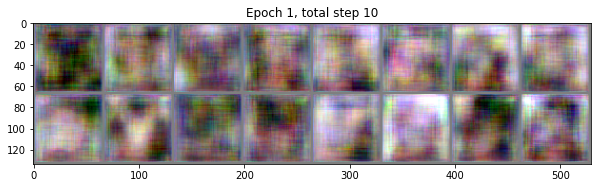

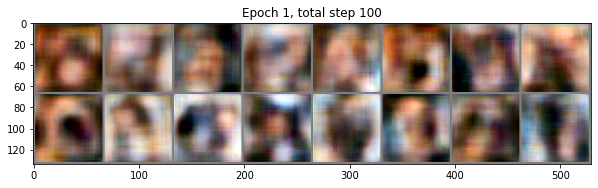

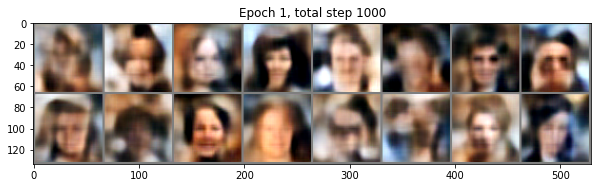

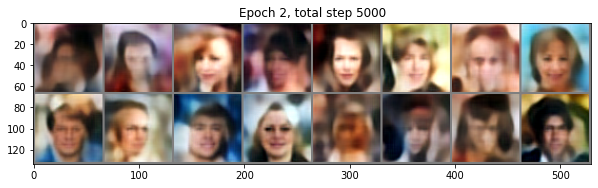

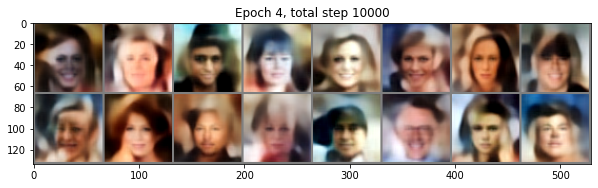

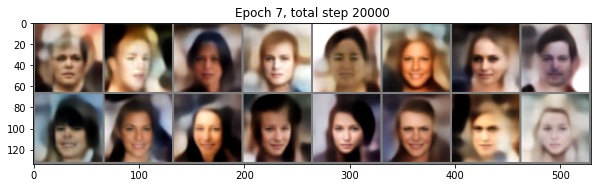

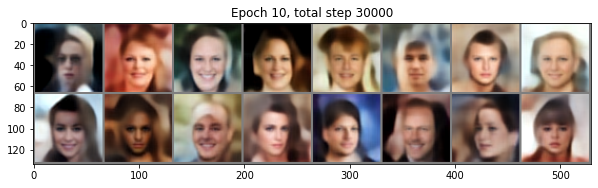

In [ ]:
epochs = 10
log_steps = [10, 100, 1000, 5000, 10000, 20000, 30000]
path = '../drive/MyDrive/Colab Notebooks/YSDA Sem 4/GAN/third/'

with tqdm(total=epochs*len(dataloader), desc=f"[KL: ?] [MSE: ?]") as pbar:
    for epoch in range(1, epochs + 1):
        train(pbar, epoch, log_steps)
        # save checkpoints
        name = f"vae_epoch_{epoch}.ckpt"
        torch.save(model.state_dict(), name)
        shutil.copy(name, path + name)

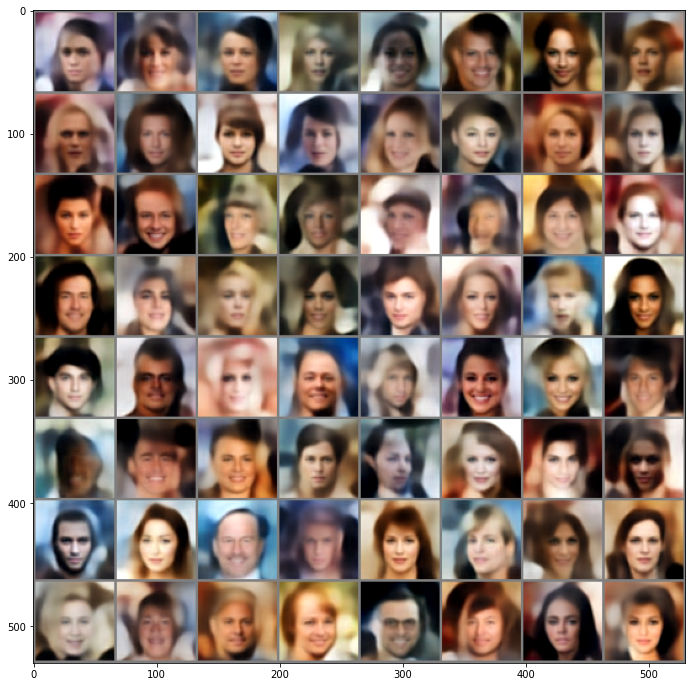

In [14]:
with torch.no_grad():
    sample = model.sample(64).cpu()
    log_img = make_grid(sample)

plt.figure(figsize=(12,12))
plt.imshow(denormalize(tensor2numpy(log_img)))

#### Evaluation

Для оценки качества сгенерированных картинок посчитаем FID между реальными картинками и сгенерированными. В качестве encoder возьмем предобученную модель MobileNetV2, при forward'е для картинки она выдает embedding размера 1000.

In [25]:
def get_representations(dataloader, model, encoder, device, sample_size):
    model = model.to(device)
    encoder = encoder.to(device)
    representations = defaultdict(list)
    with torch.no_grad():
        samples = model.sample(sample_size)
        samples = samples.to(device)
        representations['fake'] = list(encoder(samples))
    for i, (image, _) in enumerate(dataloader):
        image = image.to(device)
        representations['real'].append(encoder(image).squeeze())
        if i + 1 == sample_size:
            break
    return representations

def calculate_fid(repr1, repr2):
    from scipy.linalg import sqrtm
    mu_r, mu_g = repr1.mean(axis=0), repr2.mean(axis=0) 
    cov_r, cov_g = np.cov(repr1, rowvar=False), np.cov(repr2, rowvar=False)
    mu_delta = mu_r - mu_g
    covariances = cov_r + cov_g - 2 * sqrtm(cov_r @ cov_g)
    fid = mu_delta @ mu_delta + np.trace(covariances)
    if np.iscomplexobj(fid):
        fid = fid.real
    return fid

In [ ]:
# trained VAE
model_path = '../drive/MyDrive/Colab Notebooks/YSDA Sem 4/GAN/third/vae_epoch_10.ckpt'
model = VAE().to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

In [16]:
# pre-trained CNN
from torchvision.models import mobilenet_v2
mobilenet = mobilenet_v2(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [26]:
val_loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=1, 
                                         shuffle=False)
representations = get_representations(val_loader, model, mobilenet, device, 1000)
print(f"fake images: {len(representations['fake'])}")
print(f"real images: {len(representations['real'])}")

fake images: 1000
real images: 1000


In [27]:
fid = calculate_fid(
    torch.stack(representations['fake'], dim=0).detach().cpu().numpy(),
    torch.stack(representations['real'], dim=0).detach().cpu().numpy()
)
print(f'FID for VAE = {fid:.3f}')

FID for VAE = 10571.294


* Зафиксировали FID для обученного VAE, сравним далее с другими подходами

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [ ]:
# YOUR CODE HERE

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее в латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [11]:
# YOUR CODE HERE
# trained NF
# ---TODO---

# trained VAE
model_path = '../drive/MyDrive/Colab Notebooks/YSDA Sem 4/GAN/third/vae_epoch_10.ckpt'
model = VAE().to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

#### 1. Latent space interpolation

Два реальных изображения:

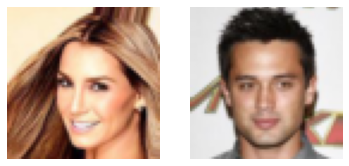

In [12]:
x_1 = dataset[0][0]
x_2 = dataset[6][0]

plt.subplot(1, 2, 1)
plot_img(x_1, None, t_invnormalize)
plt.subplot(1, 2, 2)
plot_img(x_2, None, t_invnormalize)
plt.show()

Получим их embeddings, интерполируем несколько точек между ними, декодируем  латентные векторы в изображения:

In [13]:
x_1_t = Tensor(x_1).to(device)
x_2_t = Tensor(x_2).to(device)
x_1_emb = model.encoder(x_1_t.unsqueeze(0))[0][0]
x_2_emb = model.encoder(x_2_t.unsqueeze(0))[0][0]

weights = np.linspace(0.1, 0.9, 7)
points = [torch.lerp(x_1_emb, x_2_emb, weight=w).to(device) for w in weights]

x_1_reconstructed = model.decoder(x_1_emb.unsqueeze(0))[0]
x_2_reconstructed = model.decoder(x_2_emb.unsqueeze(0))[0]
points_reconstructed = [model.decoder(p.unsqueeze(0))[0] for p in points]

all_imgs = [x_1_reconstructed] + points_reconstructed + [x_2_reconstructed]

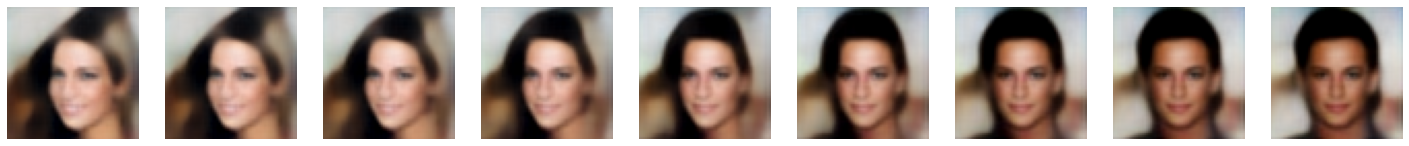

In [14]:
plt.figure(figsize=(25, 6))
n = len(all_imgs)
for i in range(n):
    plt.subplot(2, n, i+1)
    img = denormalize(tensor2numpy(all_imgs[i]))
    plt.imshow(img)
    plt.axis('off')

* Интерполяция выглядит хорошо, но качество реконструкции самих исходных изображений довольно неточное

#### 2. Find the nearest latent based

Возьмем фото МакКонахи с внешней ссылки:

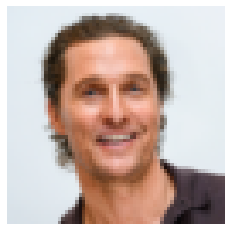

In [52]:
from PIL import Image
import requests

url = "https://media.gq.com/photos/5f885ac8bd3a91bc1eca619f/1:1/w_2968,h_2968,c_limit/Matthew%20McConaughey%20interview%20gq%20october%202020.jpg"
mcconaughey = Image.open(requests.get(url, stream=True).raw)
mcconaughey = transform(mcconaughey)

plot_img(mcconaughey, None, t_invnormalize)

Получим для него эмбеддинг и найдем пример ближайшего изображения из CelebA, на основании близости латентного представления:

In [53]:
mcconaughey_emb = model.encoder(mcconaughey.unsqueeze(0))[0]
mcconaughey_emb.shape

torch.Size([1, 100])

In [54]:
def find_nearest_image(embedding, dataset):
    nearest = None
    closest_dist = np.inf
    with tqdm(total=len(dataset)) as pbar:
        for img, _ in dataset:
            latent = model.encoder(img.unsqueeze(0))[0]
            dist = torch.cdist(embedding, latent).item()
            if dist < closest_dist:
                nearest = img
                closest_dist = dist
            pbar.update(1)
    return nearest

In [55]:
nearest = find_nearest_image(mcconaughey_emb.unsqueeze(0), dataset)

  0%|          | 0/202599 [00:00<?, ?it/s]

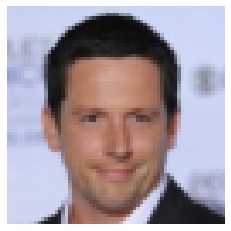

In [57]:
plot_img(nearest, None, t_invnormalize)

* Найденное ближайшее изображение по латенту не очень то похоже на исходную реальную картинку, хоть и тот же пол, поза, цвета. Видимо VAE обучился недостаточно хорошо.

#### 3. The funniest generation

In [23]:
from IPython.display import Image

# generated by VAE at epoch 10
x = Image(url='https://drive.google.com/uc?id=1g0qcuPplGbRCsemX5ptZPnzzkL3BsvXy', width=200)
# unrepeatable original
y = Image(url='https://drive.google.com/uc?id=1JJQblq29nvF-Uhb3JFHaJ8HzWSHYZy4g', width=200)

display(x, y)

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.

__Выводы__

* В ноутбуке даны примеры генерации картинок в разном количестве
* VAE показал неплохие результаты и, несмотря на свою простоту, выдавал похожие на людей изображения уже в начале первой эпохи. Выглядит, как хорошая базовая модель для такой задачи.
* NF обучить качественно не успел, поэтому по качеству сравнить с VAE нет возможности